## Text Translation (French/Mandarin to English and vice versa)

## Objective

1. To train a neural network model that can translate French words to English words and vice versa.

2. To use a pretrained transformer model that can translate Mandarin words to English words and vice versa.

## Dataset Source & Acknowledgements

Kaggle Dataset: Bilingual Sentence Pairs

https://www.kaggle.com/datasets/alincijov/bilingual-sentence-pairs

https://www.kaggle.com/code/harshjain123/machine-translation-seq2seq-lstms

In [1]:
import string
import re
import numpy as np
from numpy import array, argmax, random, take
import pandas as pd
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector,TimeDistributed,Bidirectional,Dropout
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)
import warnings
warnings.filterwarnings("ignore")
from transformers import pipeline

## 1. Training a neural network model

## German to English Translation

## Read in Dataset

In [2]:
# function to read raw text file
def read_text(filename):
        # open the file
        file = open(filename, mode='rt', encoding='utf-8')
        
        # read all text
        text = file.read()
        file.close()
        return text

In [3]:
# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

In [4]:
data = read_text("./Bilingual Sentence Pairs/fra.txt")
fra_eng = to_lines(data)
fra_eng = array(fra_eng)

In [5]:
fra_eng = fra_eng[:50000,:]

## Text Preprocessing

In [6]:
# Remove punctuation
fra_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in fra_eng[:,0]]
fra_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in fra_eng[:,1]]

fra_eng

array([['Go', 'Va ',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #1158250 (Wittydev)'],
       ['Go', 'Marche',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8090732 (Micsmithel)'],
       ['Go', 'Bouge ',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #9022935 (Micsmithel)'],
       ...,
       ['Tom liked what he saw', 'Tom a aimé ce quil a vu',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #3729268 (CM) & #5619279 (Aiji)'],
       ['Tom liked what he saw', 'Tom aima ce quil vit',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #3729268 (CM) & #5619280 (Aiji)'],
       ['Tom likes skiing too', 'Tom aussi aime skier',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2869208 (CK) & #5591397 (Aiji)']],
      dtype='<U325')

In [7]:
# convert text to lowercase
for i in range(len(fra_eng)):
    fra_eng[i,0] = fra_eng[i,0].lower()
    fra_eng[i,1] = fra_eng[i,1].lower()

In [8]:
# empty lists
eng_l = []
fra_l = []

# populate the lists with sentence lengths
for i in fra_eng[:,0]:
      eng_l.append(len(i.split()))

for i in fra_eng[:,1]:
      fra_l.append(len(i.split()))

## Text Tokenization

In [9]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [10]:
# prepare english tokenizer
eng_tokenizer = tokenization(fra_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 6042


In [11]:
# prepare french tokenizer
fra_tokenizer = tokenization(fra_eng[:, 1])
fra_vocab_size = len(fra_tokenizer.word_index) + 1

fra_length = 8
print('French Vocabulary Size: %d' % fra_vocab_size)

French Vocabulary Size: 13974


In [12]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

## Modelling

In [13]:
from sklearn.model_selection import train_test_split

# split data into train and test set
train, test = train_test_split(fra_eng, test_size=0.2, random_state = 12)

In [14]:
# prepare training data
trainX = encode_sequences(fra_tokenizer, fra_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

# prepare validation data
testX = encode_sequences(fra_tokenizer, fra_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [15]:
# build model
def define_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(Bidirectional(LSTM(units)))
    model.add(RepeatVector(out_timesteps))
    model.add(Bidirectional(LSTM(units, return_sequences=True)))
    model.add(TimeDistributed(Dense(1024, activation='relu')))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(out_vocab, activation='softmax')))
    return model

In [16]:
# model compilation
model = define_model(fra_vocab_size, eng_vocab_size, fra_length, eng_length, 512)

In [17]:
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [18]:
# use EarlyStopping in the case when val_accuracy reaches a plateau (not improving much)
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    restore_best_weights=True, 
    patience=10, 
    min_delta = 0.001)

# create model checkpoint callback to save the best model checkpoint
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath="best_checkpoint",
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

## Train the model

In [19]:
# train model
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=30, batch_size=512, validation_split = 0.2,callbacks=[es, model_checkpoint_callback], 
                    verbose=1)

Epoch 1/30
63/63 [==============================] - 131s 2s/step - loss: 3.4628 - accuracy: 0.5580 - val_loss: 2.8556 - val_accuracy: 0.5747
Epoch 2/30
63/63 [==============================] - 118s 2s/step - loss: 2.7256 - accuracy: 0.5968 - val_loss: 2.6210 - val_accuracy: 0.6039
Epoch 3/30
63/63 [==============================] - 118s 2s/step - loss: 2.4146 - accuracy: 0.6274 - val_loss: 2.3631 - val_accuracy: 0.6387
Epoch 4/30
63/63 [==============================] - 118s 2s/step - loss: 2.1403 - accuracy: 0.6556 - val_loss: 2.1398 - val_accuracy: 0.6589
Epoch 5/30
63/63 [==============================] - 118s 2s/step - loss: 1.9331 - accuracy: 0.6767 - val_loss: 2.0383 - val_accuracy: 0.6735
Epoch 6/30
63/63 [==============================] - 119s 2s/step - loss: 1.7754 - accuracy: 0.6920 - val_loss: 1.9192 - val_accuracy: 0.6890
Epoch 7/30
63/63 [==============================] - 119s 2s/step - loss: 1.6321 - accuracy: 0.7053 - val_loss: 1.8214 - val_accuracy: 0.6989
Epoch 8/30
63

## Model Evaluation

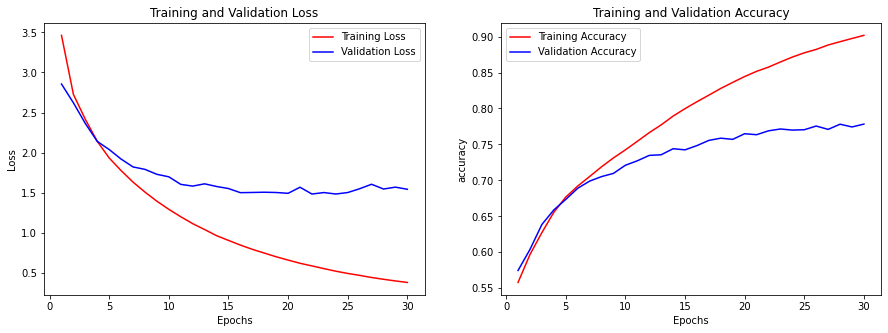

In [20]:
fig, (p1, p2) = plt.subplots(1, 2, figsize=(15,5))

x = range(1, 31)

p1.plot(x, history.history['loss'], 'r', label='Training Loss')
p1.plot(x, history.history['val_loss'], 'b', label='Validation Loss')
p1.set_title('Training and Validation Loss')
p1.set_xlabel('Epochs')
p1.set_ylabel('Loss')
p1.legend()

p2.plot(x, history.history['accuracy'], 'r', label='Training Accuracy')
p2.plot(x, history.history['val_accuracy'], 'b', label='Validation Accuracy')
p2.set_title('Training and Validation Accuracy')
p2.set_xlabel('Epochs')
p2.set_ylabel('accuracy')
p2.legend()

plt.show()

## Text Translation Prediction

In [21]:
preds = np.argmax(model.predict(testX), axis=-1)

313/313 [==============================] - 32s 92ms/step


In [22]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word

In [23]:
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t) 

    preds_text.append(' '.join(temp))

In [24]:
pred_fra2eng = pd.DataFrame({'actual_fra' : test[:,1], 'actual_eng' : test[:,0], 'predicted_eng' : preds_text})

In [25]:
# print rows
pred_fra2eng

,actual_fra,actual_eng,predicted_eng
0,je suis contente de lentendre,im glad to hear it,im glad to hear it
1,cest mort,its dead,this is
2,ne tarrête pas de grimper,keep climbing,keep no
3,je vous respecte,i respect you,ill like you
4,quest ce que tu as fait ensuite,what did you do then,what you did
...,...,...,...
9995,la leçon deux est facile,lesson two is easy,both is easy
9996,il neige làbas,its snowing there,its raining there
9997,continuez à creuser,continue digging,keep digging
9998,je pense que vous avez raison,i think youre right,i think youre right


## English to French Translation

## Modelling

In [26]:
from sklearn.model_selection import train_test_split

# split data into train and test set
train, test = train_test_split(fra_eng, test_size=0.2, random_state = 12)

In [27]:
# prepare training data
trainX = encode_sequences(eng_tokenizer, eng_length, train[:, 0])
trainY = encode_sequences(fra_tokenizer, fra_length, train[:, 1])

# prepare validation data
testX = encode_sequences(eng_tokenizer, eng_length, test[:, 0])
testY = encode_sequences(fra_tokenizer, fra_length, test[:, 1])

In [29]:
# build model
def define_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(Bidirectional(LSTM(units)))
    model.add(RepeatVector(out_timesteps))
    model.add(Bidirectional(LSTM(units, return_sequences=True)))
    model.add(TimeDistributed(Dense(1024, activation='relu')))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(out_vocab, activation='softmax')))
    return model

In [30]:
# model compilation
model = define_model(eng_vocab_size, fra_vocab_size, eng_length, fra_length, 512)

In [31]:
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [32]:
# use EarlyStopping in the case when val_accuracy reaches a plateau (not improving much)
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    restore_best_weights=True, 
    patience=10, 
    min_delta = 0.001)

# create model checkpoint callback to save the best model checkpoint
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath="best_checkpoint",
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

## Train the Model

In [33]:
# train model
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=30, batch_size=512, validation_split = 0.2,callbacks=[es, model_checkpoint_callback], 
                    verbose=1)

Epoch 1/30
63/63 [==============================] - 186s 3s/step - loss: 4.2270 - accuracy: 0.4998 - val_loss: 3.6124 - val_accuracy: 0.5170
Epoch 2/30
63/63 [==============================] - 171s 3s/step - loss: 3.4150 - accuracy: 0.5422 - val_loss: 3.2210 - val_accuracy: 0.5557
Epoch 3/30
63/63 [==============================] - 170s 3s/step - loss: 3.0681 - accuracy: 0.5775 - val_loss: 3.0513 - val_accuracy: 0.5877
Epoch 4/30
63/63 [==============================] - 170s 3s/step - loss: 2.7962 - accuracy: 0.6019 - val_loss: 2.7729 - val_accuracy: 0.6137
Epoch 5/30
63/63 [==============================] - 170s 3s/step - loss: 2.5744 - accuracy: 0.6199 - val_loss: 2.7021 - val_accuracy: 0.6185
Epoch 6/30
63/63 [==============================] - 170s 3s/step - loss: 2.4082 - accuracy: 0.6312 - val_loss: 2.5679 - val_accuracy: 0.6308
Epoch 7/30
63/63 [==============================] - 172s 3s/step - loss: 2.2627 - accuracy: 0.6407 - val_loss: 2.4714 - val_accuracy: 0.6394
Epoch 8/30
63

## Model Evaluation

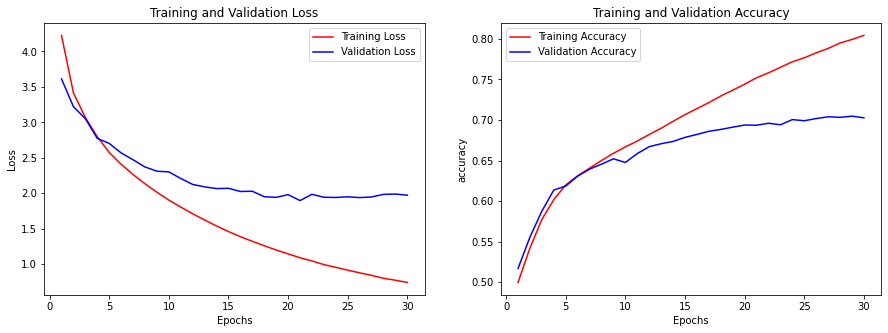

In [34]:
fig, (p1, p2) = plt.subplots(1, 2, figsize=(15,5))

x = range(1, 31)

p1.plot(x, history.history['loss'], 'r', label='Training Loss')
p1.plot(x, history.history['val_loss'], 'b', label='Validation Loss')
p1.set_title('Training and Validation Loss')
p1.set_xlabel('Epochs')
p1.set_ylabel('Loss')
p1.legend()

p2.plot(x, history.history['accuracy'], 'r', label='Training Accuracy')
p2.plot(x, history.history['val_accuracy'], 'b', label='Validation Accuracy')
p2.set_title('Training and Validation Accuracy')
p2.set_xlabel('Epochs')
p2.set_ylabel('accuracy')
p2.legend()

plt.show()

## Text Translation Prediction

In [35]:
preds = np.argmax(model.predict(testX), axis=-1)

313/313 [==============================] - 70s 213ms/step


In [36]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word

In [37]:
preds_text2 = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], fra_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], fra_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t) 

    preds_text2.append(' '.join(temp))

In [38]:
pred_eng2fra = pd.DataFrame({'actual_eng' : test[:,0], 'actual_fra' : test[:,1], 'predicted_fra' : preds_text2})

In [39]:
# print the rows
pred_eng2fra

,actual_eng,actual_fra,predicted_fra
0,im glad to hear it,je suis contente de lentendre,je suis heureux de lentendre
1,its dead,cest mort,elle est mort
2,keep climbing,ne tarrête pas de grimper,continuez à
3,i respect you,je vous respecte,je te
4,what did you do then,quest ce que tu as fait ensuite,que alors
...,...,...,...
9995,lesson two is easy,la leçon deux est facile,le est
9996,its snowing there,il neige làbas,il est là
9997,continue digging,continuez à creuser,continue à creuser
9998,i think youre right,je pense que vous avez raison,je pense que vous as raison


## 2. Using Pretrained Model (Transformer)

## English to Mandarin Translation

## Read in Dataset

In [41]:
data = read_text("./Bilingual Sentence Pairs/cmn.txt")
ch_eng = to_lines(data)
ch_eng = array(ch_eng)

In [42]:
ch_eng = ch_eng[:50000,:]

In [43]:
# empty lists
eng_l = []
ch_l = []

for i in range(len(ch_eng[:,0])):
    eng_l.append(ch_eng[:,0][i])

for i in range(len(ch_eng[:,1])):
    ch_l.append(ch_eng[:,1][i])

In [44]:
df_en2ch = pd.DataFrame({'actual_eng' : eng_l, 'actual_ch' : ch_l})
df_en2ch

,actual_eng,actual_ch
0,Hi.,嗨。
1,Hi.,你好。
2,Run.,你用跑的。
3,Wait!,等等！
4,Wait!,等一下！
...,...,...
24355,"Tom didn't know how to translate the word ""computer"" because the people he was talking to had never seen one.",汤姆不知如何翻译“计算机”一词，因为同他谈话的人从未见过一台。
24356,"Even now, I occasionally think I'd like to see you. Not the you that you are today, but the you I remember from the past.",即使是现在，我偶尔还是想见到你。不是今天的你，而是我记忆中曾经的你。
24357,"It's very easy to sound natural in your own native language, and very easy to sound unnatural in your non-native language.",你很容易把母语说得通顺流畅，却很容易把非母语说得不自然。
24358,"I got fired from the company, but since I have a little money saved up, for the time being, I won't have trouble with living expenses.",虽然我被公司解雇了，但是我还有点存款，所以目前不用担心生计问题。


## Pre-trained Model (Helsinki-NLP/opus-mt-en-zh)

In [45]:
translator_en2ch = pipeline("translation", model="Helsinki-NLP/opus-mt-en-zh")

In [46]:
df_en2ch_filtered = df_en2ch.loc[1500:24360:1000]
df_en2ch_filtered

,actual_eng,actual_ch
1500,It's time to go.,該走了。
2500,This could be fun.,這可能很好玩。
3500,I'm a stranger here.,我是這裡的外地人。
4500,You can count on her.,你可以相信她。
5500,I helped him yesterday.,昨天我帮了他。
6500,Please pass me the salt.,請把鹽遞給我。
7500,She's not as old as Mary.,她沒有瑪麗年紀大。
8500,Tom is not a friendly guy.,汤姆不是个友好的家伙。
9500,Would you like more coffee?,你想再喝點咖啡嗎？
10500,Why did you try to run away?,为什么你企图逃走？


## Text Translation Prediction

In [47]:
df_en2ch_filtered['predicted_ch']=df_en2ch_filtered['actual_eng'].apply(translator_en2ch)

for i, row in df_en2ch_filtered.iterrows():
    df_en2ch_filtered.at[i,'predicted_ch'] = next(iter(df_en2ch_filtered['predicted_ch'][i][0].values())).split(' ')[0]

df_en2ch_filtered

,actual_eng,actual_ch,predicted_ch
1500,It's time to go.,該走了。,该走了
2500,This could be fun.,這可能很好玩。,这会很有趣。
3500,I'm a stranger here.,我是這裡的外地人。,我是这里的陌生人
4500,You can count on her.,你可以相信她。,你可以依赖她
5500,I helped him yesterday.,昨天我帮了他。,我昨天帮过他
6500,Please pass me the salt.,請把鹽遞給我。,请把盐递给我
7500,She's not as old as Mary.,她沒有瑪麗年紀大。,她不像玛丽那么老
8500,Tom is not a friendly guy.,汤姆不是个友好的家伙。,汤姆不友善
9500,Would you like more coffee?,你想再喝點咖啡嗎？,还要咖啡吗?
10500,Why did you try to run away?,为什么你企图逃走？,你为什么要逃跑?


## Mandarin to English Translation

In [48]:
df_ch2en = pd.DataFrame({'actual_ch' : ch_l, 'actual_eng' : eng_l})
df_ch2en

,actual_ch,actual_eng
0,嗨。,Hi.
1,你好。,Hi.
2,你用跑的。,Run.
3,等等！,Wait!
4,等一下！,Wait!
...,...,...
24355,汤姆不知如何翻译“计算机”一词，因为同他谈话的人从未见过一台。,"Tom didn't know how to translate the word ""computer"" because the people he was talking to had never seen one."
24356,即使是现在，我偶尔还是想见到你。不是今天的你，而是我记忆中曾经的你。,"Even now, I occasionally think I'd like to see you. Not the you that you are today, but the you I remember from the past."
24357,你很容易把母语说得通顺流畅，却很容易把非母语说得不自然。,"It's very easy to sound natural in your own native language, and very easy to sound unnatural in your non-native language."
24358,虽然我被公司解雇了，但是我还有点存款，所以目前不用担心生计问题。,"I got fired from the company, but since I have a little money saved up, for the time being, I won't have trouble with living expenses."


## Pre-trained Model (Helsinki-NLP/opus-mt-zh-en)

In [49]:
translator_ch2en = pipeline("translation", model="Helsinki-NLP/opus-mt-zh-en")

In [50]:
df_ch2en_filtered = df_ch2en.loc[1000:24360:1000]
df_ch2en_filtered

,actual_ch,actual_eng
1000,他被淹死了。,He was drowned.
2000,火熄灭了。,The fire was out.
3000,她很可爱。,She is very pretty.
4000,嗨！你在这儿工作吗？,Hi! Do you work here?
5000,她用力地拍了球。,She hit the ball hard.
6000,你该学得更多。,You have to study more.
7000,我和他一起走。,He and I walked together.
8000,我要去打網球。,I am going to play tennis.
9000,我會帶你去游泳。,I will take you for a swim.
10000,我打算向她求婚。,I'm going to propose to her.


## Text Translation Prediction

In [51]:
df_ch2en_filtered['predicted_eng']=df_ch2en_filtered['actual_eng'].apply(translator_ch2en)

for i, row in df_ch2en_filtered.iterrows():
    df_ch2en_filtered.at[i,'predicted_eng'] = next(iter(df_ch2en_filtered['predicted_eng'][i][0].values()))

df_ch2en_filtered

,actual_ch,actual_eng,predicted_eng
1000,他被淹死了。,He was drowned.,He was drawn.
2000,火熄灭了。,The fire was out.,The fire was out.
3000,她很可爱。,She is very pretty.,She is very pretty.
4000,嗨！你在这儿工作吗？,Hi! Do you work here?,Do you work here?
5000,她用力地拍了球。,She hit the ball hard.,She hit the ball hard.
6000,你该学得更多。,You have to study more.,You have to study more.
7000,我和他一起走。,He and I walked together.,He and I walked together.
8000,我要去打網球。,I am going to play tennis.,I am going to play tennis.
9000,我會帶你去游泳。,I will take you for a swim.,I will take you for a swim.
10000,我打算向她求婚。,I'm going to propose to her.,I'm going to propose to her.


## End of Notebook